<a href="https://colab.research.google.com/github/vic1030/Data_Science_Learning/blob/main/DBSCAN%E5%AE%9E%E4%BE%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 数据生成和标准化。

2. 使用 K-距离图选择 ε 参数。

3. 应用 DBSCAN 进行聚类。

4. 可视化聚类结果。

5. 使用轮廓系数评估聚类效果。

6. 进行参数优化。

DBSCAN 可以有效地处理具有复杂形状的聚类，并识别噪声，但参数选择对于聚类效果至关重要。通过 K-距离图和网格搜索等方法，我们可以优化 DBSCAN 的性能。在大家实际实验中，根据数据的特性和需求选择合适的参数和算法是关键。

In [1]:
#1.首先，我们需要导入必要的库并生成月亮形状的数据集。
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# 设置 Seaborn 样式
sns.set(style="whitegrid")

# 生成月亮形状的数据集
X, y = make_moons(n_samples=3000, noise=0.1, random_state=0)

In [11]:
a = X.shape
b = y.shape
print(a)
print(b)

(3000, 2)
(3000,)


2. 数据预处理

对数据进行标准化处理，以适应 DBSCAN 的要求。

In [12]:

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

3. 确定 DBSCAN 的参数

使用 K-距离图来选择 ε（邻域距离阈值）参数，并选择合适的 MinPts（最小邻居数）。

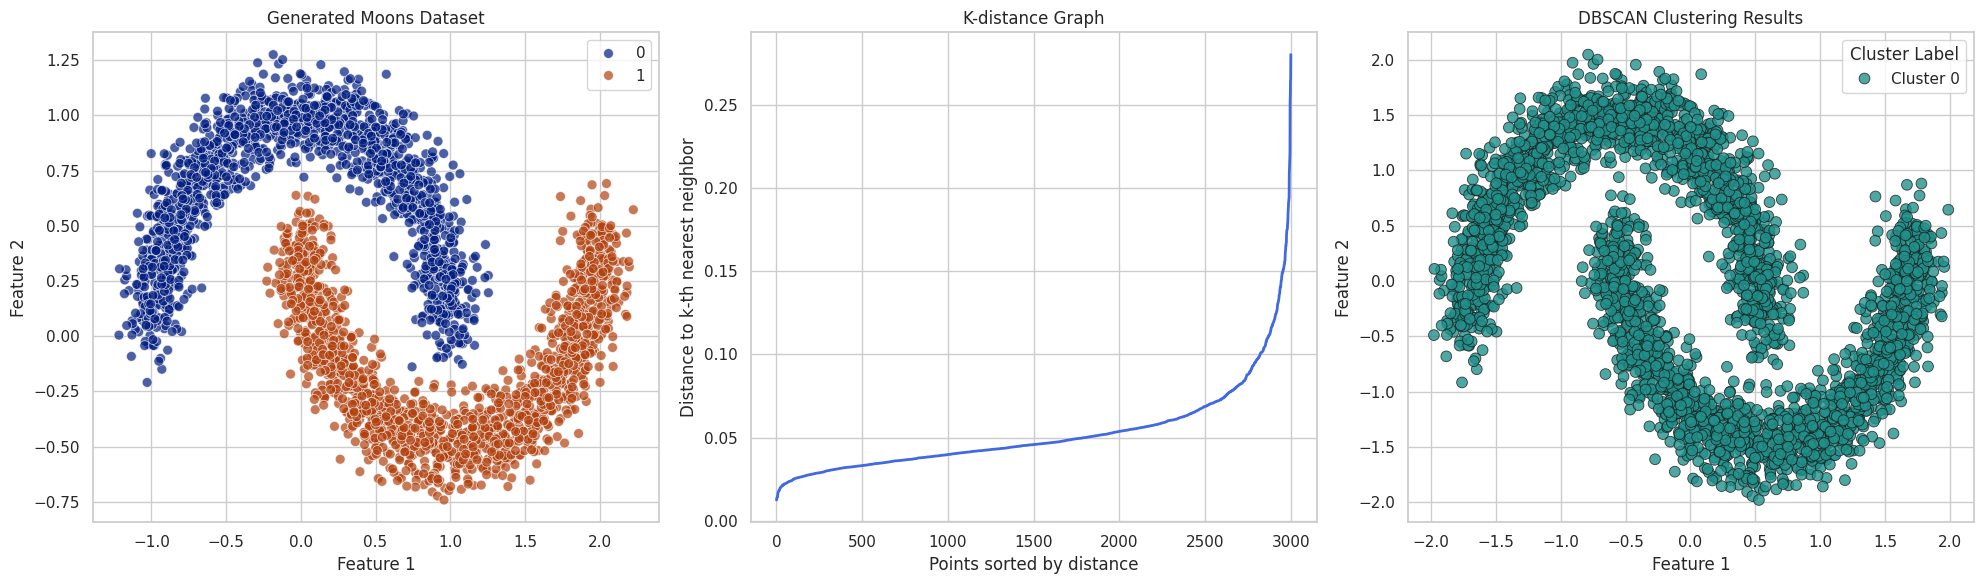

Estimated number of clusters: 1
Number of noise points: 0


In [17]:
# 设置 MinPts（邻居数）
min_samples = 5

# 使用 NearestNeighbors 计算 K 距离
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)

# 计算第 min_samples 个最近邻的距离
distances = np.sort(distances[:, -1], axis=0) #升序值

# 创建图形及其子图
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# 可视化原始数据
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='dark', s=50, alpha=0.7, ax=axs[0])
axs[0].set_title('Generated Moons Dataset')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')

# 绘制 K-距离图
axs[1].plot(distances, color='royalblue', linestyle='-', linewidth=2)
axs[1].set_title('K-distance Graph')
axs[1].set_xlabel('Points sorted by distance')
axs[1].set_ylabel('Distance to k-th nearest neighbor')
'''
4. 应用 DBSCAN 聚类

选择 ε 值和 MinPts，应用 DBSCAN 聚类，并分析结果。
'''

# 应用 DBSCAN 聚类
epsilon = 0.3  # 通过 K-距离图选择的值
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(X_scaled)

# 可视化聚类结果
scatter = sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis', s=60, alpha=0.8, edgecolor='k', ax=axs[2])
axs[2].set_title('DBSCAN Clustering Results')
axs[2].set_xlabel('Feature 1')
axs[2].set_ylabel('Feature 2')
handles, labels_legend = scatter.get_legend_handles_labels()
axs[2].legend(handles, [f'Cluster {i}' for i in set(labels) if i != -1] + ['Noise'], title='Cluster Label')

# 调整布局
plt.tight_layout()
plt.show()

# 输出聚类结果的基本信息
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # -1 代表噪声点
n_noise = list(labels).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

5. 评估聚类效果

使用轮廓系数（Silhouette Score）来评估聚类效果。

In [18]:
# 计算轮廓系数
if n_clusters > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
else:
    print("Silhouette Score cannot be computed, only one cluster found or all points are noise.")

Silhouette Score cannot be computed, only one cluster found or all points are noise.


6. 优化

DBSCAN 的参数选择对于聚类效果至关重要。2 点优化方式：

1. 网格搜索：尝试不同的 ε 和 MinPts 值组合，通过评估聚类效果来选择最佳参数。

2. 自动选择 ε：除了 K-距离图，还可以使用密度图等方法来自动选择 ε 值。

**所有样本的si的均值称为聚类结果的轮廓系数，是该聚类是否合理、有效的度量**

si接近1，则说明样本i聚类合理；<br>si接近-1，则说明样本i更应该分类到另外的簇；<br>若si 近似为0，则说明样本i在两个簇的边界上

In [19]:
from sklearn.model_selection import ParameterGrid

# 网格搜索参数优化
param_grid = {'eps': [0.2, 0.3, 0.4, 0.5], 'min_samples': [3, 5, 7, 10]}
best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X_scaled)
    if len(set(labels)) > 1:  # 仅当找到多个簇时计算轮廓系数
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.3f}")

Best Parameters: {'eps': 0.2, 'min_samples': 10}
Best Silhouette Score: 0.315
